In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, multivariate_normal

from kdelearn.kde import KDE
from kdelearn.ckde import CKDE
from kdelearn.ckde_tasks import CKDEClassification, CKDEOutliersDetection, CKDEClustering
from kdelearn.metrics import pi_kf, density_silhouette
from kdelearn.bandwidth_selection import normal_reference, direct_plugin

# Dataset parameters

Parametry mieszaniny rozkładów Gaussa używanych w dalszych przykładach:

$$
seed=1
$$

$$
m=1000
$$

$$
m_1=0.25m
$$

\begin{equation*}
E_1 =
\left(\begin{array}{c}
-3 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_1 =
\left(\begin{array}{cc}\ 
4 & -1.4\\
-1.4 & 1
\end{array}\right)
\end{equation*}


$$
m_2=0.5m
$$

\begin{equation*}
E_2 =
\left(\begin{array}{c}
2 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_2 =
\left(\begin{array}{cc}\ 
1 & 0.7\\
0.7 & 1
\end{array}\right)
\end{equation*}


$$
m_3=0.15m
$$

\begin{equation*}
E_3 =
\left(\begin{array}{c}
5 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_3 =
\left(\begin{array}{cc}\ 
1 & 0.9\\
0.9 & 1
\end{array}\right)
\end{equation*}


$$
m_4=0.1m
$$

\begin{equation*}
E_4 =
\left(\begin{array}{c}
0 \\
0
\end{array}\right)
\end{equation*}

\begin{equation*}
Cov_4 =
\left(\begin{array}{cc}\ 
16 & 0\\
0 & 4
\end{array}\right)
\end{equation*}

Uwaga: Dane z 4 członu to traktowane są jako szum

In [72]:
np.random.seed(1)

# Data
m_train = 1000
n_x, n_y = 1, 1

## class 1
m_train1 = int(0.25 * m_train)
mean1 = [-3, 0]
cov1 = [[4, -1.4],
        [-1.4, 1]]
z_train1 = np.random.multivariate_normal(mean1, cov1, m_train1)
x_train1 = z_train1[:, [0]]
y_train1 = z_train1[:, [1]]
labels_train1 = np.full(m_train1, 1, dtype=np.int32)

## class 2
m_train2 = int(0.5 * m_train)
mean2 = [2, 0]
cov2 = [[1, 0.7],
        [0.7, 1]]
z_train2 = np.random.multivariate_normal(mean2, cov2, m_train2)
x_train2 = z_train2[:, [0]]
y_train2 = z_train2[:, [1]]
labels_train2 = np.full(m_train2, 2, dtype=np.int32)

## class 3
m_train3 = int(0.15 * m_train)
mean3 = [5, 0]
cov3 = [[1, 0.9],
        [0.9, 1]]
z_train3 = np.random.multivariate_normal(mean3, cov3, m_train3)
x_train3 = z_train3[:, [0]]
y_train3 = z_train3[:, [1]]
labels_train3 = np.full(m_train3, 3, dtype=np.int32)

## class 4
m_train4 = int(0.1 * m_train)
mean4 = [0, 0]
cov4 = [[16, 0],
        [0, 4]]
z_train4 = np.random.multivariate_normal(mean4, cov4, m_train4)
x_train4 = z_train4[:, [0]]
y_train4 = z_train4[:, [1]]
labels_train4 = np.full(m_train4, 4, dtype=np.int32)

## 
x_train = np.concatenate((x_train1, x_train2, x_train3, x_train4), axis=0)
y_train = np.concatenate((y_train1, y_train2, y_train3, y_train4), axis=0)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3, labels_train4))

\newpage

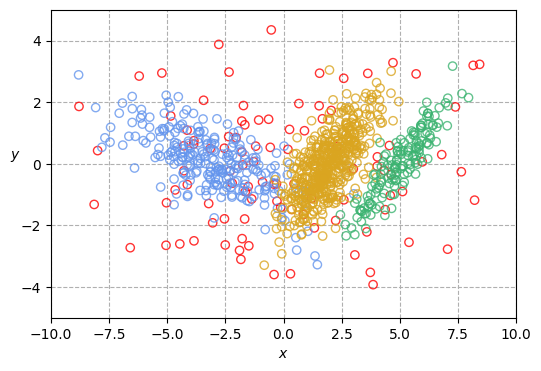

In [73]:
plt.figure(figsize=(6, 4))

plt.scatter(x_train4, y_train4, facecolors="none", edgecolors="red", zorder=2, alpha=0.8)
plt.scatter(x_train1, y_train1, facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8)
plt.scatter(x_train2, y_train2, facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8)
plt.scatter(x_train3, y_train3, facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8)

plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.grid(linestyle="--")
plt.show()

# $y^*=2$

In [74]:
y_star = np.array([2.0] * n_y)

## Outliers detection (r=0.1)

Do detekcji elementów nietypowych stosowana jest metoda podstawień rzędu 2.

### Fitting

In [75]:
outlier_detector = CKDEOutliersDetection().fit(x_train, y_train, y_star, bandwidth_method="direct_plugin")

x_grid = np.linspace(-10, 10, 1000)[:, None]

ckde = CKDE().fit(x_train, y_train, y_star, bandwidth_method="direct_plugin")
scores, d_train0 = ckde.pdf(x_grid)

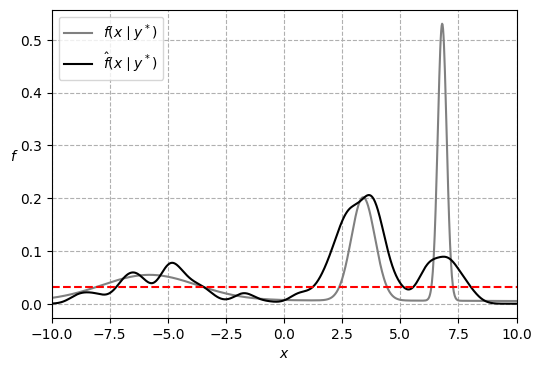

In [76]:
true_dist1 = m_train1/m_train * norm.pdf(x_grid, loc=-5.8, scale=2.04)
true_dist2 = m_train1/m_train * norm.pdf(x_grid, loc=3.4, scale=0.51)
true_dist3 = m_train1/m_train * norm.pdf(x_grid, loc=6.8, scale=0.19)
true_dist4 = m_train1/m_train * norm.pdf(x_grid, loc=0, scale=16)
true_dist = true_dist1 + true_dist2 + true_dist3 + true_dist4


# Plot
plt.figure(figsize=(6, 4))

plt.plot(x_grid, true_dist, c="grey", label="$f(x \mid y^*)$")
plt.plot(x_grid, scores, c="k", label="$\hat{f}(x \mid y^*)$")
plt.hlines(outlier_detector.threshold, -10, 10, linestyle="--", color="r")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

### Testing 1

Testowanie na pierwotnym zbiorze

In [77]:
outlier_detector = CKDEOutliersDetection().fit(x_train, y_train, y_star, bandwidth_method="direct_plugin")
labels_pred = outlier_detector.predict(x_train)

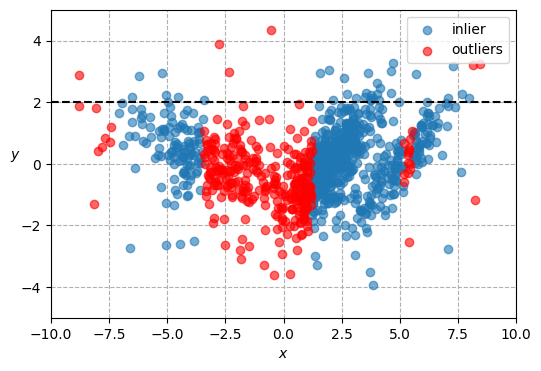

In [78]:
plt.figure(figsize=(6, 4))

plt.scatter(x_train[labels_pred==0], y_train[labels_pred==0], zorder=2, alpha=0.6, label="inlier")
plt.scatter(x_train[labels_pred==1], y_train[labels_pred==1], zorder=2, alpha=0.6, c="red", label="outliers")
plt.hlines(y_star[0], -10, 10, color="k", linestyle="--")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
plt.show()

In [79]:
metrics = pi_kf(x_train, x_train, labels_pred, d_train0, d_train0)
print(f"Wskaźnik jakości (PI_kf): {metrics:.6f}")

Wskaźnik jakości (PI_kf): 0.321991


#### Dopasowanie parametru wygładzania (na siatce)

In [80]:
bandwidth_x_multiplier = np.arange(0.5, 2.025, 0.025)[::-1]
bandwidth_y_multiplier = np.arange(0.5, 2.025, 0.025)[::-1]

metrics_list = np.zeros((bandwidth_x_multiplier.size, bandwidth_x_multiplier.size))
for i0, i in enumerate(bandwidth_x_multiplier):
    for j0, j in enumerate(bandwidth_y_multiplier):
        bandwidth_x = direct_plugin(x_train, None, "gaussian") * i
        bandwidth_y = direct_plugin(y_train, None, "gaussian") * j
        outlier_detector = CKDEOutliersDetection().fit(x_train, y_train, y_star, bandwidth_x=bandwidth_x, bandwidth_y=bandwidth_y)
        labels_pred = outlier_detector.predict(x_train)

        metrics = pi_kf(x_train, x_train, labels_pred, d_train0, d_train0)
        metrics_list[i0, j0] = metrics

best_indexes = np.where(metrics_list == metrics_list.min())
best_bandwidth_x_multipliers = bandwidth_x_multiplier[best_indexes[0][:]]
best_bandwidth_y_multipliers = bandwidth_y_multiplier[best_indexes[1][:]]

best_single_idx = np.linalg.norm(np.vstack((best_bandwidth_x_multipliers, best_bandwidth_y_multipliers)) - 1, axis=0).argmin()
best_bandwidth_x_multiplier = best_bandwidth_x_multipliers[best_single_idx]
best_bandwidth_y_multiplier = best_bandwidth_y_multipliers[best_single_idx]

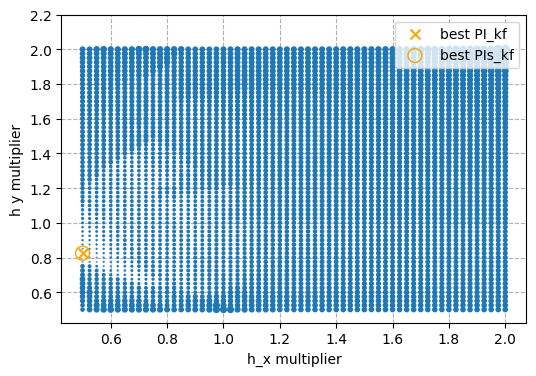

Najlepszy wskaźnik jakości (PI_kf): 0.228983


In [81]:
x1v, x2v = np.meshgrid(bandwidth_x_multiplier, bandwidth_y_multiplier)
x1p = x1v.reshape(-1, 1)
x2p = x2v.reshape(-1, 1)


plt.figure(figsize=(6, 4))

plt.scatter(x1p, x2p, s=30*((metrics_list - metrics_list.min()) / (metrics_list.max() - metrics_list.min())).T.reshape(-1), zorder=2)
plt.scatter(best_bandwidth_x_multiplier, best_bandwidth_y_multiplier, s=50,
            zorder=2, label="best PI_kf", marker="x", c="orange")
plt.scatter(best_bandwidth_x_multipliers, best_bandwidth_y_multipliers, s=100,
            zorder=2, label="best PIs_kf", facecolors="none", edgecolors="orange")

plt.legend()
plt.xlabel("h_x multiplier")
plt.ylabel("h y multiplier")
plt.ylim(top=2.2)
plt.grid(linestyle="--")
plt.show()

print(f"Najlepszy wskaźnik jakości (PI_kf): {metrics_list.min():.6f}")

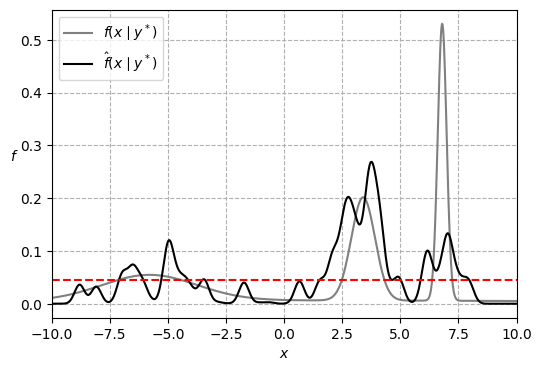

In [82]:
bandwidth_x = direct_plugin(x_train, None, "gaussian") * best_bandwidth_x_multiplier
bandwidth_y = direct_plugin(y_train, None, "gaussian") * best_bandwidth_y_multiplier

ckde = CKDE().fit(x_train, y_train, y_star, bandwidth_x=bandwidth_x, bandwidth_y=bandwidth_y)
scores, _ = ckde.pdf(x_grid)
outlier_detector = CKDEOutliersDetection().fit(x_train, y_train, y_star, bandwidth_x=bandwidth_x, bandwidth_y=bandwidth_y)

# Plot
plt.figure(figsize=(6, 4))

plt.plot(x_grid, true_dist, c="grey", label="$f(x \mid y^*)$")
plt.plot(x_grid, scores, c="k", label="$\hat{f}(x \mid y^*)$")
plt.hlines(outlier_detector.threshold, -10, 10, linestyle="--", color="r")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

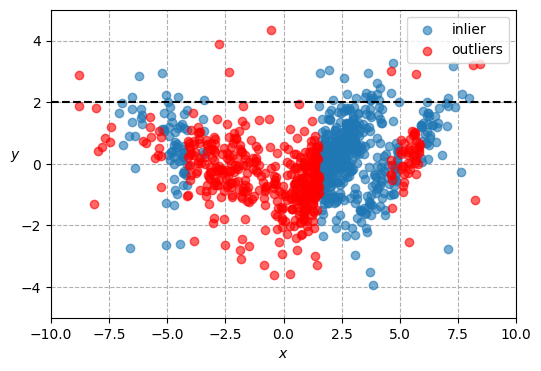

In [83]:
labels_pred = outlier_detector.predict(x_train)
    
plt.figure(figsize=(6, 4))

plt.scatter(x_train[labels_pred==0], y_train[labels_pred==0], zorder=2, alpha=0.6, label="inlier")
plt.scatter(x_train[labels_pred==1], y_train[labels_pred==1], zorder=2, alpha=0.6, c="red", label="outliers")
plt.hlines(y_star[0], -10, 10, color="k", linestyle="--")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
plt.show()

### Testing 2

Testowanie na nowym zbiorze ($m_{test}=1000$) wylosowanym z referencyjnego rozkładu mieszaniny gaussowskiej $f(x \mid y^*=2)$ 

In [84]:
np.random.seed(0)

# m_test = 1000
mixture_params = np.array([[-5.8, 2.04],
                           [3.4, 0.51],
                           [6.8, 0.19],
                           [0, 16]])
mixture_weights = np.array([m_train1 / m_train,
                            m_train2 / m_train,
                            m_train3 / m_train,
                            m_train4 / m_train])

mixture_idx = np.random.choice(mixture_weights.size, size=m_train, replace=True, p=mixture_weights)
x_test = np.fromiter((np.random.normal(*mixture_params[i]) for i in mixture_idx), dtype=np.float64)[:, None]

In [85]:
outlier_detector = CKDEOutliersDetection().fit(x_train, y_train, y_star, bandwidth_method="direct_plugin", stage=2)
labels_pred = outlier_detector.predict(x_test)

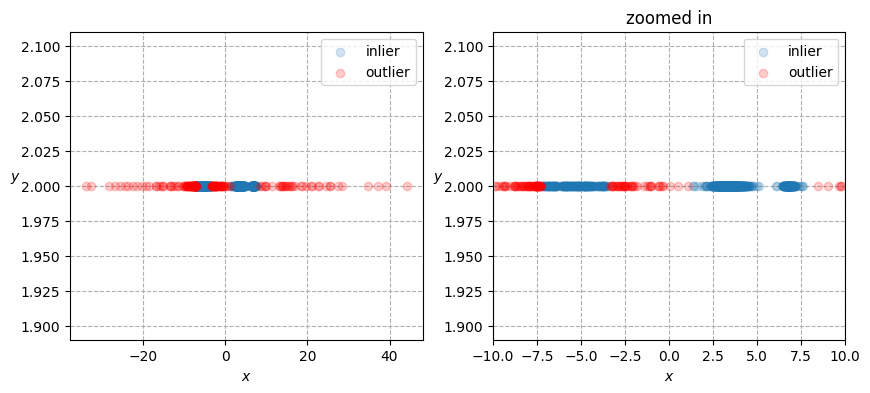

In [86]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(x_test[labels_pred==0], x_test[labels_pred==0]*0 + y_star[0], alpha=0.2, zorder=2, label="inlier")
axs[0].scatter(x_test[labels_pred==1], x_test[labels_pred==1]*0 + y_star[0], alpha=0.2, c="red", zorder=2, label="outlier")
axs[0].legend()
axs[0].grid(linestyle="--")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$", rotation=0)

axs[1].scatter(x_test[labels_pred==0], x_test[labels_pred==0]*0 + y_star[0], alpha=0.2, zorder=2, label="inlier")
axs[1].scatter(x_test[labels_pred==1], x_test[labels_pred==1]*0 + y_star[0], alpha=0.2, c="red", zorder=2, label="outlier")
axs[1].set_title("zoomed in")
axs[1].legend()
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$y$", rotation=0)
axs[1].set_xlim(-10, 10)
axs[1].grid(linestyle="--")

plt.show()

In [87]:
metrics = pi_kf(x_train, x_test, labels_pred, d_train0)
print(f"Wskaźnik jakości (PI_kf): {metrics:.6f}")

Wskaźnik jakości (PI_kf): 0.209317


#### Dopasowanie parametru wygładzania (na siatce)

In [88]:
bandwidth_x_multiplier = np.arange(0.5, 2.025, 0.025)[::-1]
bandwidth_y_multiplier = np.arange(0.5, 2.025, 0.025)[::-1]

metrics_list = np.zeros((bandwidth_x_multiplier.size, bandwidth_x_multiplier.size))
for i0, i in enumerate(bandwidth_x_multiplier):
    for j0, j in enumerate(bandwidth_y_multiplier):
        bandwidth_x = direct_plugin(x_train, None, "gaussian") * i
        bandwidth_y = direct_plugin(y_train, None, "gaussian") * j
        outlier_detector = CKDEOutliersDetection().fit(x_train, y_train, y_star, bandwidth_x=bandwidth_x, bandwidth_y=bandwidth_y)
        labels_pred = outlier_detector.predict(x_test)

        metrics = pi_kf(x_train, x_test, labels_pred, d_train0)
        metrics_list[i0, j0] = metrics

best_indexes = np.where(metrics_list == metrics_list.min())
best_bandwidth_x_multipliers = bandwidth_x_multiplier[best_indexes[0][:]]
best_bandwidth_y_multipliers = bandwidth_y_multiplier[best_indexes[1][:]]

best_single_idx = np.linalg.norm(np.vstack((best_bandwidth_x_multipliers, best_bandwidth_y_multipliers)) - 1, axis=0).argmin()
best_bandwidth_x_multiplier = best_bandwidth_x_multipliers[best_single_idx]
best_bandwidth_y_multiplier = best_bandwidth_y_multipliers[best_single_idx]

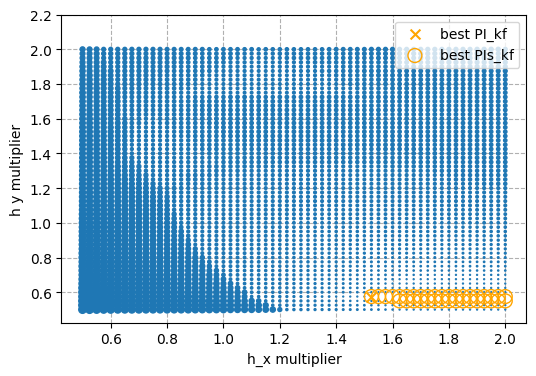

Najlepszy wskaźnik jakości (PI_kf): 0.192745


In [89]:
x1v, x2v = np.meshgrid(bandwidth_x_multiplier, bandwidth_y_multiplier)
x1p = x1v.reshape(-1, 1)
x2p = x2v.reshape(-1, 1)


plt.figure(figsize=(6, 4))

plt.scatter(x1p, x2p, s=30*((metrics_list - metrics_list.min()) / (metrics_list.max() - metrics_list.min())).T.reshape(-1), zorder=2)
plt.scatter(best_bandwidth_x_multiplier, best_bandwidth_y_multiplier, s=50,
            zorder=2, label="best PI_kf", marker="x", c="orange")
plt.scatter(best_bandwidth_x_multipliers, best_bandwidth_y_multipliers, s=100,
            zorder=2, label="best PIs_kf", facecolors="none", edgecolors="orange")

plt.legend()
plt.xlabel("h_x multiplier")
plt.ylabel("h y multiplier")
plt.ylim(top=2.2)
plt.grid(linestyle="--")
plt.show()

print(f"Najlepszy wskaźnik jakości (PI_kf): {metrics_list.min():.6f}")

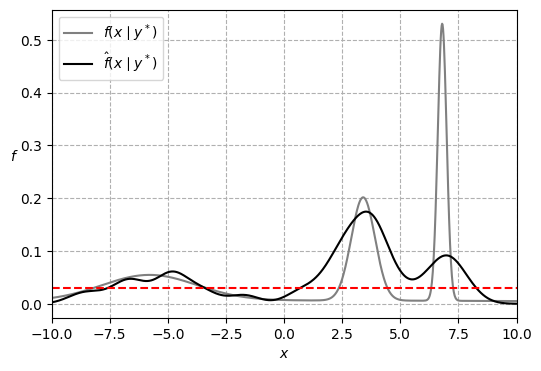

In [90]:
bandwidth_x = direct_plugin(x_train, None, "gaussian") * best_bandwidth_x_multiplier
bandwidth_y = direct_plugin(y_train, None, "gaussian") * best_bandwidth_y_multiplier

ckde = CKDE().fit(x_train, y_train, y_star, bandwidth_x=bandwidth_x, bandwidth_y=bandwidth_y)
scores, _ = ckde.pdf(x_grid)
outlier_detector = CKDEOutliersDetection().fit(x_train, y_train, y_star, bandwidth_x=bandwidth_x, bandwidth_y=bandwidth_y)

# Plot
plt.figure(figsize=(6, 4))

plt.plot(x_grid, true_dist, c="grey", label="$f(x \mid y^*)$")
plt.plot(x_grid, scores, c="k", label="$\hat{f}(x \mid y^*)$")
plt.hlines(outlier_detector.threshold, -10, 10, linestyle="--", color="r")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

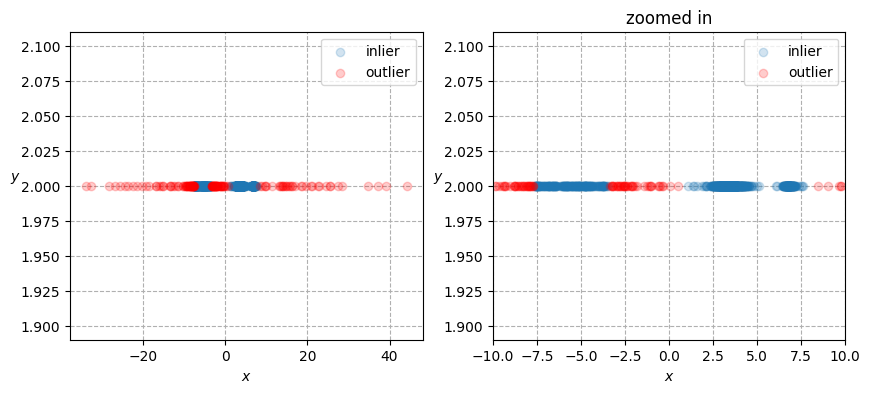

In [91]:
labels_pred = outlier_detector.predict(x_test)


fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].scatter(x_test[labels_pred==0], x_test[labels_pred==0]*0 + y_star[0], alpha=0.2, zorder=2, label="inlier")
axs[0].scatter(x_test[labels_pred==1], x_test[labels_pred==1]*0 + y_star[0], alpha=0.2, c="red", zorder=2, label="outlier")
axs[0].legend()
axs[0].grid(linestyle="--")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$y$", rotation=0)

axs[1].scatter(x_test[labels_pred==0], x_test[labels_pred==0]*0 + y_star[0], alpha=0.2, zorder=2, label="inlier")
axs[1].scatter(x_test[labels_pred==1], x_test[labels_pred==1]*0 + y_star[0], alpha=0.2, c="red", zorder=2, label="outlier")
axs[1].set_title("zoomed in")
axs[1].legend()
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$y$", rotation=0)
axs[1].set_xlim(-10, 10)
axs[1].grid(linestyle="--")

plt.show()

## Clustering

- Do klasteryzacji stosowana jest metoda podstawień rzędu do 2.
- Szum (czwarty czynnik) nie jest tutaj brany pod uwagę

In [92]:
# Data
x_train = np.concatenate((x_train1, x_train2, x_train3), axis=0)
y_train = np.concatenate((y_train1, y_train2, y_train3), axis=0)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3))

m_train = x_train.shape[0]

## Fitting

In [93]:
clustering = CKDEClustering().fit(x_train, y_train, y_star, bandwidth_method="direct_plugin", stage=2)

x_grid = np.linspace(-10, 10, 1000)[:, None]

ckde = CKDE().fit(x_train, y_train, y_star, bandwidth_method="direct_plugin", stage=2)
scores, d_train = ckde.pdf(x_grid)

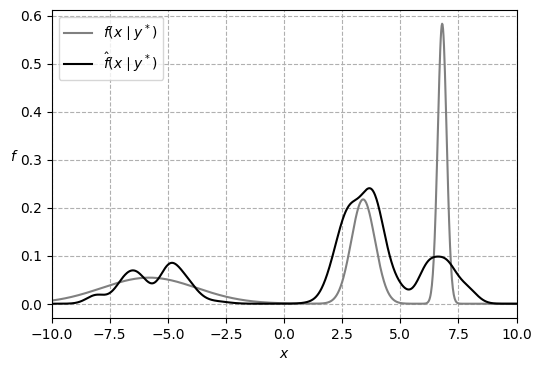

In [94]:
true_dist1 = m_train1/m_train * norm.pdf(x_grid, loc=-5.8, scale=2.04)
true_dist2 = m_train1/m_train * norm.pdf(x_grid, loc=3.4, scale=0.51)
true_dist3 = m_train1/m_train * norm.pdf(x_grid, loc=6.8, scale=0.19)
true_dist = true_dist1 + true_dist2 + true_dist3

# Plot
plt.figure(figsize=(6, 4))

plt.plot(x_grid, true_dist, c="grey", label="$f(x \mid y^*)$")
plt.plot(x_grid, scores, c="k", label="$\hat{f}(x \mid y^*)$")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

### Testing 1

Testowanie na pierwotnym zbiorze

In [95]:
clustering = CKDEClustering().fit(x_train, y_train, y_star, bandwidth_method="direct_plugin", stage=2)
labels_pred = clustering.predict(x_train)

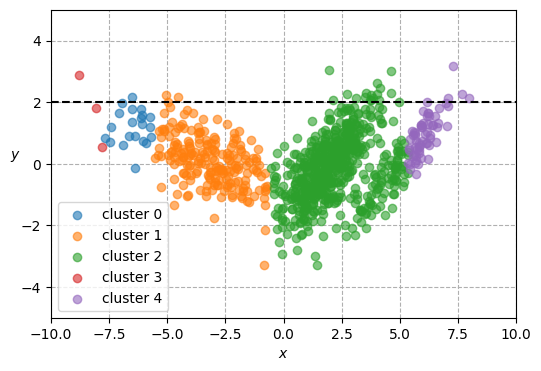

In [96]:
plt.figure(figsize=(6, 4))

for i in np.unique(labels_pred):
    plt.scatter(x_train[labels_pred==i], y_train[labels_pred==i], zorder=2, alpha=0.6, label=f"cluster {i}")
plt.hlines(y_star[0], -10, 10, color="k", linestyle="--")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
plt.show()

In [97]:
dbs_scores, dbs_mean = density_silhouette(x_train, labels_pred, weights_test=d_train, weights2=d_train)
print(f"Wskaźnik jakości (dbs): {dbs_mean:.6f}")

Wskaźnik jakości (dbs): 0.448165


#### Dopasowanie parametru wygładzania (na siatce)

In [98]:
bandwidth_x_multiplier = np.arange(0.5, 2.025, 0.025)[::-1]
bandwidth_y_multiplier = np.arange(0.5, 2.025, 0.025)[::-1]

metrics_list = np.zeros((bandwidth_x_multiplier.size, bandwidth_x_multiplier.size))
for i0, i in enumerate(bandwidth_x_multiplier):
    for j0, j in enumerate(bandwidth_y_multiplier):
        bandwidth_x = direct_plugin(x_train, None, "gaussian") * i
        bandwidth_y = direct_plugin(y_train, None, "gaussian") * j
        clustering = CKDEClustering().fit(x_train, y_train, y_star, bandwidth_x=bandwidth_x, bandwidth_y=bandwidth_y)

        labels_pred = clustering.predict(x_train)
        
        dbs_scores, dbs_mean = density_silhouette(x_train, labels_pred, weights_test=d_train, weights2=d_train)
        metrics_list[i0, j0] = dbs_mean

best_indexes = np.where(metrics_list == metrics_list.max())
best_bandwidth_x_multipliers = bandwidth_x_multiplier[best_indexes[0][:]]
best_bandwidth_y_multipliers = bandwidth_y_multiplier[best_indexes[1][:]]

best_single_idx = np.linalg.norm(np.vstack((best_bandwidth_x_multipliers, best_bandwidth_y_multipliers)) - 1, axis=0).argmin()
best_bandwidth_x_multiplier = best_bandwidth_x_multipliers[best_single_idx]
best_bandwidth_y_multiplier = best_bandwidth_y_multipliers[best_single_idx]

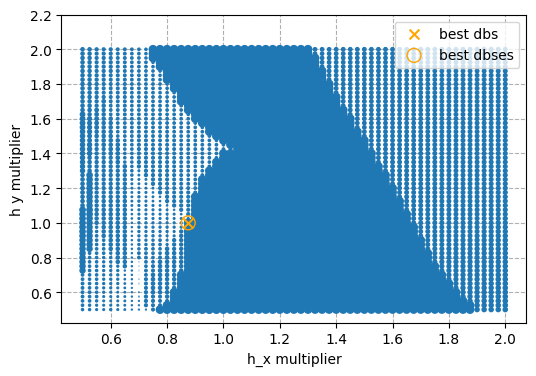

Najlepszy wskaźnik jakości (dbs): 0.473703


In [99]:
x1v, x2v = np.meshgrid(bandwidth_x_multiplier, bandwidth_y_multiplier)
x1p = x1v.reshape(-1, 1)
x2p = x2v.reshape(-1, 1)


plt.figure(figsize=(6, 4))

plt.scatter(x1p, x2p, s=30*((metrics_list - metrics_list.min()) / (metrics_list.max() - metrics_list.min())).T.reshape(-1), zorder=2)
plt.scatter(best_bandwidth_x_multiplier, best_bandwidth_y_multiplier, s=50,
            zorder=2, label="best dbs", marker="x", c="orange")
plt.scatter(best_bandwidth_x_multipliers, best_bandwidth_y_multipliers, s=100,
            zorder=2, label="best dbses", facecolors="none", edgecolors="orange")

plt.legend()
plt.xlabel("h_x multiplier")
plt.ylabel("h y multiplier")
plt.ylim(top=2.2)
plt.grid(linestyle="--")
plt.show()

print(f"Najlepszy wskaźnik jakości (dbs): {metrics_list.max():.6f}")

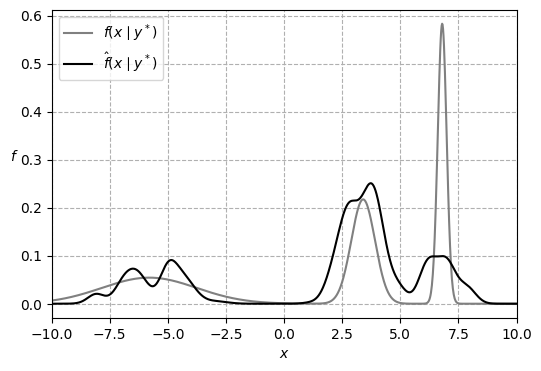

In [100]:
bandwidth_x = direct_plugin(x_train, None, "gaussian") * best_bandwidth_x_multiplier
bandwidth_y = direct_plugin(y_train, None, "gaussian") * best_bandwidth_y_multiplier

ckde = CKDE().fit(x_train, y_train, y_star, bandwidth_x=bandwidth_x, bandwidth_y=bandwidth_y)
scores, _ = ckde.pdf(x_grid)


# Plot
plt.figure(figsize=(6, 4))

plt.plot(x_grid, true_dist, c="grey", label="$f(x \mid y^*)$")
plt.plot(x_grid, scores, c="k", label="$\hat{f}(x \mid y^*)$")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

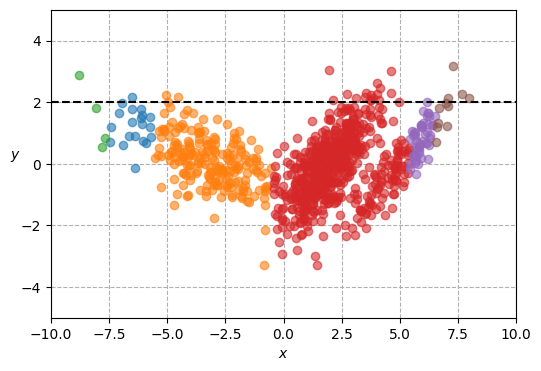

In [101]:
clustering = CKDEClustering().fit(x_train, y_train, y_star, bandwidth_x=bandwidth_x, bandwidth_y=bandwidth_y)
labels_pred = clustering.predict(x_train)

plt.figure(figsize=(6, 4))

for i in np.unique(labels_pred):
    plt.scatter(x_train[labels_pred==i], y_train[labels_pred==i], zorder=2, alpha=0.6)
plt.hlines(y_star[0], -10, 10, color="k", linestyle="--")

plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
plt.show()

### Testing 2

Testowanie na nowym zbiorze ($m_{test}=900$) wylosowanym z referencyjnego rozkładu mieszaniny gaussowskiej $f(x \mid y^*=2)$ 

In [102]:
np.random.seed(0)

# m_test = 900
mixture_params = np.array([[-5.8, 2.04],
                           [3.4, 0.51],
                           [6.8, 0.19]])
mixture_weights = np.array([m_train1 / m_train,
                            m_train2 / m_train,
                            m_train3 / m_train])

mixture_idx = np.random.choice(mixture_weights.size, size=m_train, replace=True, p=mixture_weights)
x_test = np.fromiter((np.random.normal(*mixture_params[i]) for i in mixture_idx), dtype=np.float64)[:, None]

In [103]:
clustering = CKDEClustering().fit(x_train, y_train, y_star, bandwidth_method="direct_plugin", stage=2)
labels_pred = clustering.predict(x_test)

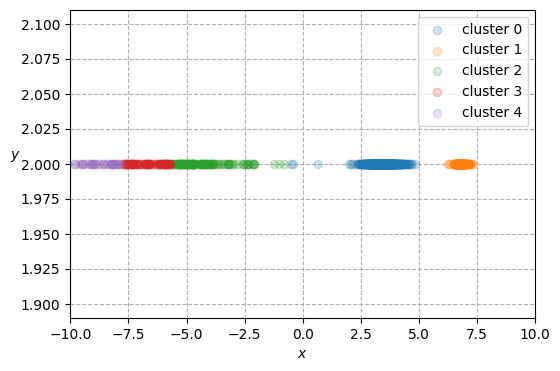

In [104]:
plt.figure(figsize=(6, 4))

for i in np.unique(labels_pred):
    plt.scatter(x_test[labels_pred==i], x_test[labels_pred==i]*0 + y_star[0], alpha=0.2, zorder=2, label=f"cluster {i}")
plt.legend()
plt.grid(linestyle="--")
plt.xlim(-10, 10)
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)

plt.show()

In [105]:
dbs_scores, dbs_mean = density_silhouette(x_test, labels_pred)
print(f"Wskaźnik jakości (kde dbs): {dbs_mean:.6f}")

Wskaźnik jakości (kde dbs): 0.405139


#### Dopasowanie parametru wygładzania (na siatce)

In [106]:
bandwidth_x_multiplier = np.arange(0.5, 2.025, 0.025)[::-1]
bandwidth_y_multiplier = np.arange(0.5, 2.025, 0.025)[::-1]

metrics_list = np.zeros((bandwidth_x_multiplier.size, bandwidth_x_multiplier.size))
for i0, i in enumerate(bandwidth_x_multiplier):
    for j0, j in enumerate(bandwidth_y_multiplier):
        bandwidth_x = direct_plugin(x_train, None, "gaussian") * i
        bandwidth_y = direct_plugin(y_train, None, "gaussian") * j
        clustering = CKDEClustering().fit(x_train, y_train, y_star, bandwidth_x=bandwidth_x, bandwidth_y=bandwidth_y)

        labels_pred = clustering.predict(x_test)

        dbs_scores, dbs_mean = density_silhouette(x_test, labels_pred)
        metrics_list[i0, j0] = dbs_mean

best_indexes = np.where(metrics_list == metrics_list.max())
best_bandwidth_x_multipliers = bandwidth_x_multiplier[best_indexes[0][:]]
best_bandwidth_y_multipliers = bandwidth_y_multiplier[best_indexes[1][:]]

best_single_idx = np.linalg.norm(np.vstack((best_bandwidth_x_multipliers, best_bandwidth_y_multipliers)) - 1, axis=0).argmin()
best_bandwidth_x_multiplier = best_bandwidth_x_multipliers[best_single_idx]
best_bandwidth_y_multiplier = best_bandwidth_y_multipliers[best_single_idx]

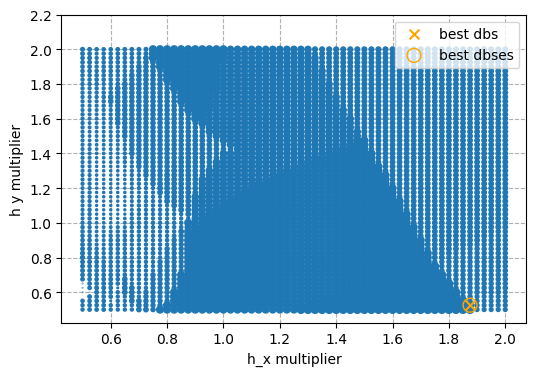

Najlepszy wskaźnik jakości (kde dbs): 0.482231


In [107]:
x1v, x2v = np.meshgrid(bandwidth_x_multiplier, bandwidth_y_multiplier)
x1p = x1v.reshape(-1, 1)
x2p = x2v.reshape(-1, 1)


plt.figure(figsize=(6, 4))

plt.scatter(x1p, x2p, s=30*((metrics_list - metrics_list.min()) / (metrics_list.max() - metrics_list.min())).T.reshape(-1), zorder=2)
plt.scatter(best_bandwidth_x_multiplier, best_bandwidth_y_multiplier, s=50,
            zorder=2, label="best dbs", marker="x", c="orange")
plt.scatter(best_bandwidth_x_multipliers, best_bandwidth_y_multipliers, s=100,
            zorder=2, label="best dbses", facecolors="none", edgecolors="orange")

plt.legend()
plt.xlabel("h_x multiplier")
plt.ylabel("h y multiplier")
plt.ylim(top=2.2)
plt.grid(linestyle="--")
plt.show()

print(f"Najlepszy wskaźnik jakości (kde dbs): {metrics_list.max():.6f}")

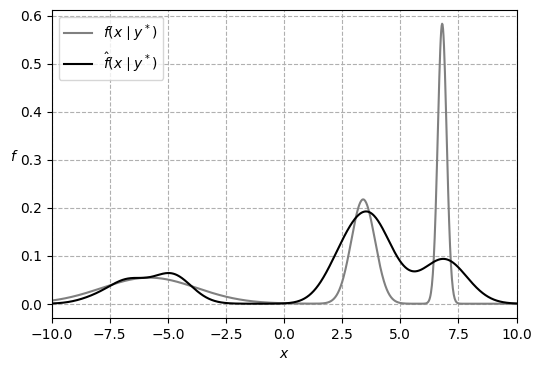

In [108]:
bandwidth_x = direct_plugin(x_train, None, "gaussian") * best_bandwidth_x_multiplier
bandwidth_y = direct_plugin(y_train, None, "gaussian") * best_bandwidth_y_multiplier

ckde = CKDE().fit(x_train, y_train, y_star, bandwidth_x=bandwidth_x, bandwidth_y=bandwidth_y)
scores, _ = ckde.pdf(x_grid)


# Plot
plt.figure(figsize=(6, 4))

plt.plot(x_grid, true_dist, c="grey", label="$f(x \mid y^*)$")
plt.plot(x_grid, scores, c="k", label="$\hat{f}(x \mid y^*)$")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")

plt.show()

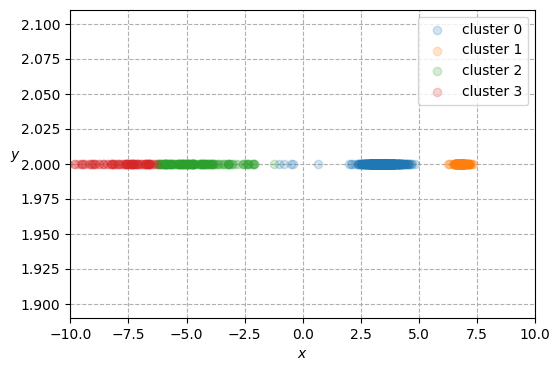

In [109]:
clustering = CKDEClustering().fit(x_train, y_train, y_star, bandwidth_x=bandwidth_x, bandwidth_y=bandwidth_y)
labels_pred = clustering.predict(x_test)


plt.figure(figsize=(6, 4))

for i in np.unique(labels_pred):
    plt.scatter(x_test[labels_pred==i], x_test[labels_pred==i]*0 + y_star[0], alpha=0.2, zorder=2, label=f"cluster {i}")
plt.legend()
plt.grid(linestyle="--")
plt.xlim(-10, 10)
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)

plt.show()

## Classification

- Stosowana jest metoda podstawień rzędu 2 do estymacji rozkładów klas
- Szum (czwarty czynnik) nie jest tutaj brany pod uwagę

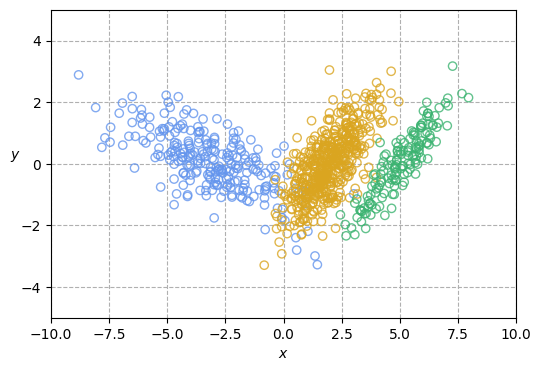

In [110]:
plt.figure(figsize=(6, 4))

plt.scatter(x_train1, y_train1, facecolors="none", edgecolors="cornflowerblue", zorder=2, alpha=0.8)
plt.scatter(x_train2, y_train2, facecolors="none", edgecolors="goldenrod", zorder=2, alpha=0.8)
plt.scatter(x_train3, y_train3, facecolors="none", edgecolors="mediumseagreen", zorder=2, alpha=0.8)

plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.grid(linestyle="--")
plt.show()

### Fitting

In [111]:
# Data
x_train = np.concatenate((x_train1, x_train2, x_train3), axis=0)
y_train = np.concatenate((y_train1, y_train2, y_train3), axis=0)
labels_train = np.concatenate((labels_train1, labels_train2, labels_train3))

m_train = x_train.shape[0]
x_grid = np.linspace(-10, 10, 1000)[:, None]

ckde = CKDE().fit(x_train, y_train, y_star, bandwidth_method="direct_plugin")
_, d_train = ckde.pdf(x_grid)

ckde1 = CKDE().fit(x_train1, y_train1, y_star, bandwidth_method="direct_plugin")
scores1, _ = ckde1.pdf(x_grid)
ckde2 = CKDE().fit(x_train2, y_train2, y_star, bandwidth_method="direct_plugin")
scores2, _ = ckde2.pdf(x_grid)
ckde3 = CKDE().fit(x_train3, y_train3, y_star, bandwidth_method="direct_plugin")
scores3, _ = ckde3.pdf(x_grid)

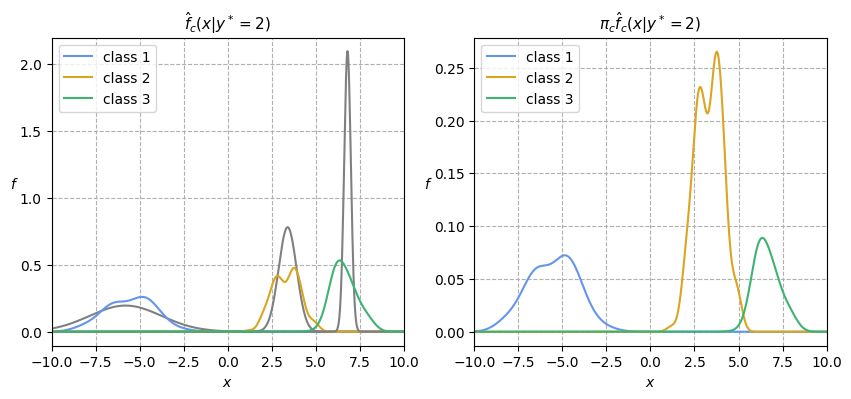

In [112]:
# https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Bivariate_case_2

fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

true_dist1 = norm.pdf(x_grid, loc=-5.8, scale=2.04)
axs[0].plot(x_grid, true_dist1, c="grey")
axs[0].plot(x_grid, scores1, c="cornflowerblue", label="class 1")
true_dist2 = norm.pdf(x_grid, loc=3.4, scale=0.51)
axs[0].plot(x_grid, true_dist2, c="grey")
axs[0].plot(x_grid, scores2, c="goldenrod", label="class 2")
true_dist3 = norm.pdf(x_grid, loc=6.8, scale=0.19)
axs[0].plot(x_grid, true_dist3, c="grey")
axs[0].plot(x_grid, scores3, c="mediumseagreen", label="class 3")
axs[0].set_title("$\hat{f}_c(x|y^*=2)$", fontsize=11)
axs[0].legend(fontsize=10)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$f$", rotation=0)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=2.2)
axs[0].grid(linestyle="--")

axs[1].plot(x_grid, m_train1 / m_train * scores1, c="cornflowerblue", label="class 1")
axs[1].plot(x_grid, m_train2 / m_train * scores2, c="goldenrod", label="class 2")
axs[1].plot(x_grid, m_train3 / m_train * scores3, c="mediumseagreen", label="class 3")
axs[1].set_title("$\\pi_c \\hat{f}_c(x|y^*=2)$", fontsize=11)
axs[1].legend(fontsize=10)
axs[1].set_xlim(-10, 10)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$f$", rotation=0)
axs[1].grid(linestyle="--")

plt.show()

### Testing 1

Testowanie na pierwotnym (treningowym) zbiorze

In [113]:
classifier = CKDEClassification().fit(x_train, y_train, y_star, labels_train, bandwidth_method="direct_plugin")
labels_pred = classifier.predict(x_train)

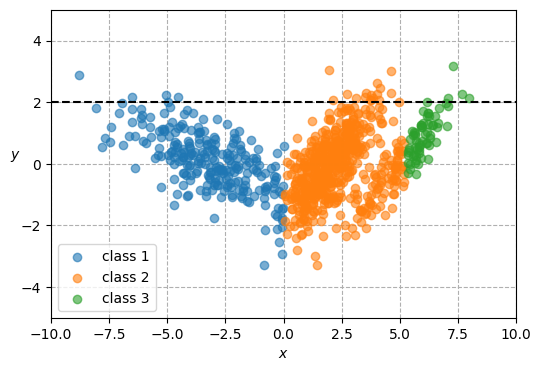

In [114]:
plt.figure(figsize=(6, 4))

plt.scatter(x_train[labels_pred==1], y_train[labels_pred==1], zorder=2, alpha=0.6, label="class 1")
plt.scatter(x_train[labels_pred==2], y_train[labels_pred==2], zorder=2, alpha=0.6, label="class 2")
plt.scatter(x_train[labels_pred==3], y_train[labels_pred==3], zorder=2, alpha=0.6, label="class 3")
plt.hlines(y_star[0], -10, 10, color="k", linestyle="--")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
plt.show()

In [115]:
print(f"Wskaźnik jakości (ważona dokładność): {np.average(labels_pred == labels_train, weights=d_train):.6f}")

Wskaźnik jakości (ważona dokładność): 0.999997


#### Dopasowanie parametru wygładzania (na siatce)

In [116]:
ulabels = np.unique(labels_train)  # Sorted unique labels
n_classes = ulabels.shape[0]

bandwidth_x_multiplier = np.arange(0.5, 2.025, 0.025)[::-1]
bandwidth_y_multiplier = np.arange(0.5, 2.025, 0.025)[::-1]

metrics_list = np.zeros((bandwidth_x_multiplier.size, bandwidth_x_multiplier.size))
for i0, i in enumerate(bandwidth_x_multiplier):
    for j0, j in enumerate(bandwidth_y_multiplier):
        bandwidths_x = np.zeros((n_classes, 1))
        bandwidths_y = np.zeros((n_classes, 1))
        for idx, label in enumerate(ulabels):
            mask = labels_train == label
            bandwidths_x[idx, :] = direct_plugin(x_train[mask]) * i
            bandwidths_y[idx, :] = direct_plugin(y_train[mask]) * j
            
        classifier = CKDEClassification().fit(x_train, y_train, y_star, labels_train,
                                              bandwidths_x=bandwidths_x, bandwidths_y=bandwidths_y)
        labels_pred = classifier.predict(x_train)
        
        metrics = np.average(labels_pred == labels_train, weights=d_train)
        metrics_list[i0, j0] = metrics

best_indexes = np.where(metrics_list == metrics_list.max())
best_bandwidth_x_multipliers = bandwidth_x_multiplier[best_indexes[0][:]]
best_bandwidth_y_multipliers = bandwidth_y_multiplier[best_indexes[1][:]]

best_single_idx = np.linalg.norm(np.vstack((best_bandwidth_x_multipliers, best_bandwidth_y_multipliers)) - 1, axis=0).argmin()
best_bandwidth_x_multiplier = best_bandwidth_x_multipliers[best_single_idx]
best_bandwidth_y_multiplier = best_bandwidth_y_multipliers[best_single_idx]

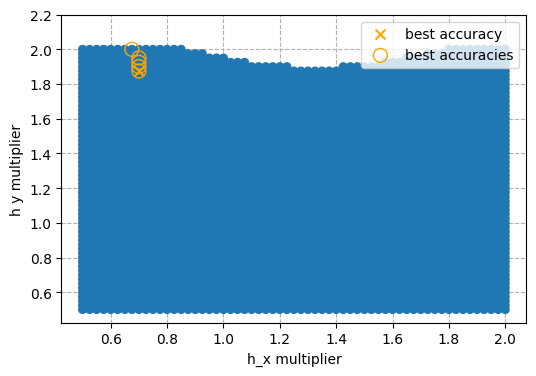

Najlepszy wskaźnik jakości (ważona dokładność): 0.999999


In [117]:
x1v, x2v = np.meshgrid(bandwidth_x_multiplier, bandwidth_y_multiplier)
x1p = x1v.reshape(-1, 1)
x2p = x2v.reshape(-1, 1)


plt.figure(figsize=(6, 4))

plt.scatter(x1p, x2p, s=30*((metrics_list - metrics_list.min()) / (metrics_list.max() - metrics_list.min())).T.reshape(-1), zorder=2)
plt.scatter(best_bandwidth_x_multiplier, best_bandwidth_y_multiplier, s=50,
            zorder=2, label="best accuracy", marker="x", c="orange")
plt.scatter(best_bandwidth_x_multipliers, best_bandwidth_y_multipliers, s=100,
            zorder=2, label="best accuracies", facecolors="none", edgecolors="orange")

plt.legend()
plt.xlabel("h_x multiplier")
plt.ylabel("h y multiplier")
plt.ylim(top=2.2)
plt.grid(linestyle="--")
plt.show()

print(f"Najlepszy wskaźnik jakości (ważona dokładność): {metrics_list.max():.6f}")

In [118]:
bandwidths_x = np.zeros((n_classes, 1))
bandwidths_y = np.zeros((n_classes, 1))
for idx, label in enumerate(ulabels):
    mask = labels_train == label
    bandwidths_x[idx, :] = direct_plugin(x_train[mask])
    bandwidths_y[idx, :] = direct_plugin(y_train[mask])

bandwidths_x *= best_bandwidth_x_multiplier
bandwidths_y *= best_bandwidth_y_multiplier


ckde1 = CKDE().fit(x_train1, y_train1, y_star, bandwidth_x=bandwidths_x[0, :], bandwidth_y=bandwidths_y[0, :])
scores1, _ = ckde1.pdf(x_grid)
ckde2 = CKDE().fit(x_train2, y_train2, y_star, bandwidth_x=bandwidths_x[1, :], bandwidth_y=bandwidths_y[1, :])
scores2, _ = ckde2.pdf(x_grid)
ckde3 = CKDE().fit(x_train3, y_train3, y_star, bandwidth_x=bandwidths_x[2, :], bandwidth_y=bandwidths_y[2, :])
scores3, _ = ckde3.pdf(x_grid)

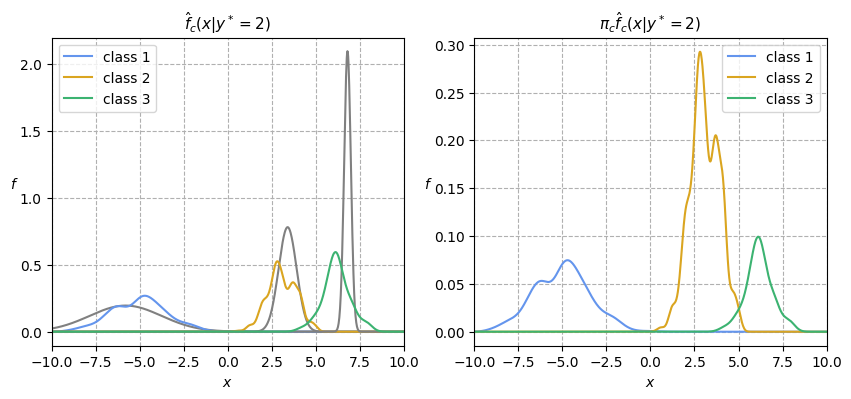

In [119]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

true_dist1 = norm.pdf(x_grid, loc=-5.8, scale=2.04)
axs[0].plot(x_grid, true_dist1, c="grey")
axs[0].plot(x_grid, scores1, c="cornflowerblue", label="class 1")
true_dist2 = norm.pdf(x_grid, loc=3.4, scale=0.51)
axs[0].plot(x_grid, true_dist2, c="grey")
axs[0].plot(x_grid, scores2, c="goldenrod", label="class 2")
true_dist3 = norm.pdf(x_grid, loc=6.8, scale=0.19)
axs[0].plot(x_grid, true_dist3, c="grey")
axs[0].plot(x_grid, scores3, c="mediumseagreen", label="class 3")
axs[0].set_title("$\hat{f}_c(x|y^*=2)$", fontsize=11)
axs[0].legend(fontsize=10)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$f$", rotation=0)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=2.2)
axs[0].grid(linestyle="--")

axs[1].plot(x_grid, m_train1 / m_train * scores1, c="cornflowerblue", label="class 1")
axs[1].plot(x_grid, m_train2 / m_train * scores2, c="goldenrod", label="class 2")
axs[1].plot(x_grid, m_train3 / m_train * scores3, c="mediumseagreen", label="class 3")
axs[1].set_title("$\\pi_c \\hat{f}_c(x|y^*=2)$", fontsize=11)
axs[1].legend(fontsize=10)
axs[1].set_xlim(-10, 10)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$f$", rotation=0)
axs[1].grid(linestyle="--")

plt.show()

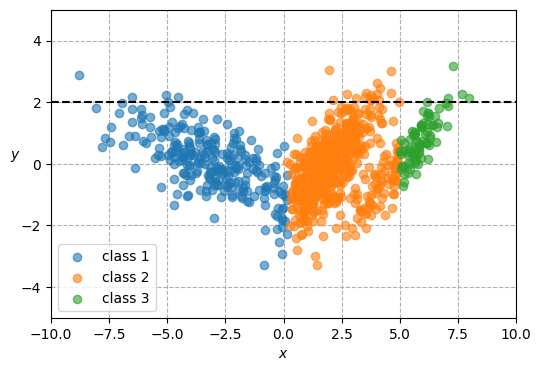

In [120]:
classifier = CKDEClassification().fit(x_train, y_train, y_star, labels_train,
                                      bandwidths_x=bandwidths_x, bandwidths_y=bandwidths_y)
labels_pred = classifier.predict(x_train)


plt.figure(figsize=(6, 4))

plt.scatter(x_train[labels_pred==1], y_train[labels_pred==1], zorder=2, alpha=0.6, label="class 1")
plt.scatter(x_train[labels_pred==2], y_train[labels_pred==2], zorder=2, alpha=0.6, label="class 2")
plt.scatter(x_train[labels_pred==3], y_train[labels_pred==3], zorder=2, alpha=0.6, label="class 3")
plt.hlines(y_star[0], -10, 10, color="k", linestyle="--")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.ylim(-5, 5)
plt.grid(linestyle="--")
plt.show()

### Testing 2

Testowanie na nowym zbiorze (bez szumu) ($m_{test}=900$) wylosowanym z referencyjnego rozkładów warunkowych $f_c(x \mid y^*=2)$ 

In [121]:
np.random.seed(0)

# Test data
m_test1 = m_train1
x_test1 = np.random.normal(loc=-5.8, scale=2.04, size=m_test1)[:,None]
labels_test1 = np.full(m_test1, 1, dtype=np.int32)

m_test2 = m_train2
x_test2 = np.random.normal(loc=3.4, scale=0.51, size=m_test2)[:,None]
labels_test2 = np.full(m_test2, 2, dtype=np.int32)

m_test3 = m_train3
x_test3 = np.random.normal(loc=6.8, scale=0.19, size=m_test3)[:,None]
labels_test3 = np.full(m_test3, 3, dtype=np.int32)

x_test = np.concatenate((x_test1, x_test2, x_test3), axis=0)
labels_test = np.concatenate((labels_test1, labels_test2, labels_test3))
m_test = x_test.shape[0]

# Classify
classifier = CKDEClassification().fit(x_train, y_train, y_star, labels_train, bandwidth_method="direct_plugin")
labels_pred = classifier.predict(x_test)

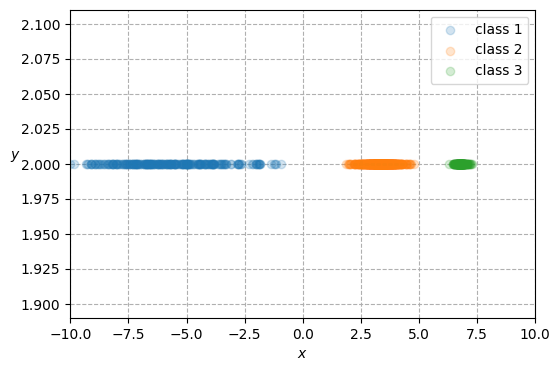

In [122]:
plt.figure(figsize=(6, 4))

plt.scatter(x_test[labels_pred==1], x_test[labels_pred==1]*0 + y_star[0], alpha=0.2, zorder=2, label="class 1")
plt.scatter(x_test[labels_pred==2], x_test[labels_pred==2]*0 + y_star[0], alpha=0.2, zorder=2, label="class 2")
plt.scatter(x_test[labels_pred==3], x_test[labels_pred==3]*0 + y_star[0], alpha=0.2, zorder=2, label="class 3")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")
plt.show()

In [123]:
print(f"Wskaźnik jakości (dokładność): {np.mean(labels_pred == labels_train):.6f}")

Wskaźnik jakości (dokładność): 1.000000


#### Dopasowanie parametru wygładzania (na siatce)

In [124]:
ulabels = np.unique(labels_train)  # Sorted unique labels
n_classes = ulabels.shape[0]

bandwidth_x_multiplier = np.arange(0.5, 2.025, 0.025)[::-1]
bandwidth_y_multiplier = np.arange(0.5, 2.025, 0.025)[::-1]

metrics_list = np.zeros((bandwidth_x_multiplier.size, bandwidth_x_multiplier.size))
for i0, i in enumerate(bandwidth_x_multiplier):
    for j0, j in enumerate(bandwidth_y_multiplier):
        bandwidths_x = np.zeros((n_classes, 1))
        bandwidths_y = np.zeros((n_classes, 1))
        for idx, label in enumerate(ulabels):
            mask = labels_train == label
            bandwidths_x[idx, :] = direct_plugin(x_train[mask]) * i
            bandwidths_y[idx, :] = direct_plugin(y_train[mask]) * j
            
        classifier = CKDEClassification().fit(x_train, y_train, y_star, labels_train,
                                              bandwidths_x=bandwidths_x, bandwidths_y=bandwidths_y)
        labels_pred = classifier.predict(x_test)
        

        metrics = np.mean(labels_pred == labels_train)
        metrics_list[i0, j0] = metrics

best_indexes = np.where(metrics_list == metrics_list.max())
best_bandwidth_x_multipliers = bandwidth_x_multiplier[best_indexes[0][:]]
best_bandwidth_y_multipliers = bandwidth_y_multiplier[best_indexes[1][:]]

best_single_idx = np.linalg.norm(np.vstack((best_bandwidth_x_multipliers, best_bandwidth_y_multipliers)) - 1, axis=0).argmin()
best_bandwidth_x_multiplier = best_bandwidth_x_multipliers[best_single_idx]
best_bandwidth_y_multiplier = best_bandwidth_y_multipliers[best_single_idx]

/tmp/ipykernel_11247/1945257160.py:8: RuntimeWarning: invalid value encountered in divide
  plt.scatter(x1p, x2p, s=30*((metrics_list - metrics_list.min()) / (metrics_list.max() - metrics_list.min())).T.reshape(-1), zorder=2)


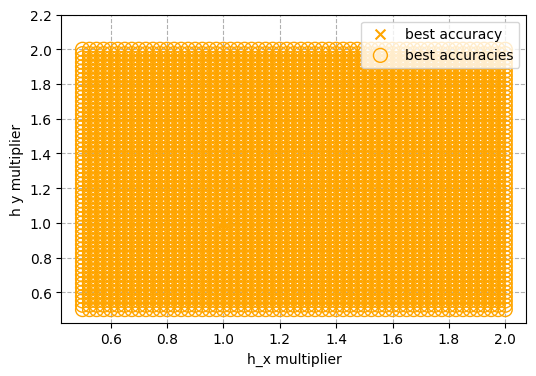

Najlepszy wskaźnik jakości (ważona dokładność): 1.000000


In [125]:
x1v, x2v = np.meshgrid(bandwidth_x_multiplier, bandwidth_y_multiplier)
x1p = x1v.reshape(-1, 1)
x2p = x2v.reshape(-1, 1)


plt.figure(figsize=(6, 4))

plt.scatter(x1p, x2p, s=30*((metrics_list - metrics_list.min()) / (metrics_list.max() - metrics_list.min())).T.reshape(-1), zorder=2)
plt.scatter(best_bandwidth_x_multiplier, best_bandwidth_y_multiplier, s=50,
            zorder=2, label="best accuracy", marker="x", c="orange")
plt.scatter(best_bandwidth_x_multipliers, best_bandwidth_y_multipliers, s=100,
            zorder=2, label="best accuracies", facecolors="none", edgecolors="orange")

plt.legend()
plt.xlabel("h_x multiplier")
plt.ylabel("h y multiplier")
plt.ylim(top=2.2)
plt.grid(linestyle="--")
plt.show()

print(f"Najlepszy wskaźnik jakości (ważona dokładność): {metrics_list.max():.6f}")

In [126]:
bandwidths_x = np.zeros((n_classes, 1))
bandwidths_y = np.zeros((n_classes, 1))
for idx, label in enumerate(ulabels):
    mask = labels_train == label
    bandwidths_x[idx, :] = direct_plugin(x_train[mask])
    bandwidths_y[idx, :] = direct_plugin(y_train[mask])

bandwidths_x *= best_bandwidth_x_multiplier
bandwidths_y *= best_bandwidth_y_multiplier


ckde1 = CKDE().fit(x_train1, y_train1, y_star, bandwidth_x=bandwidths_x[0, :], bandwidth_y=bandwidths_y[0, :])
scores1, _ = ckde1.pdf(x_grid)
ckde2 = CKDE().fit(x_train2, y_train2, y_star, bandwidth_x=bandwidths_x[1, :], bandwidth_y=bandwidths_y[1, :])
scores2, _ = ckde2.pdf(x_grid)
ckde3 = CKDE().fit(x_train3, y_train3, y_star, bandwidth_x=bandwidths_x[2, :], bandwidth_y=bandwidths_y[2, :])
scores3, _ = ckde3.pdf(x_grid)

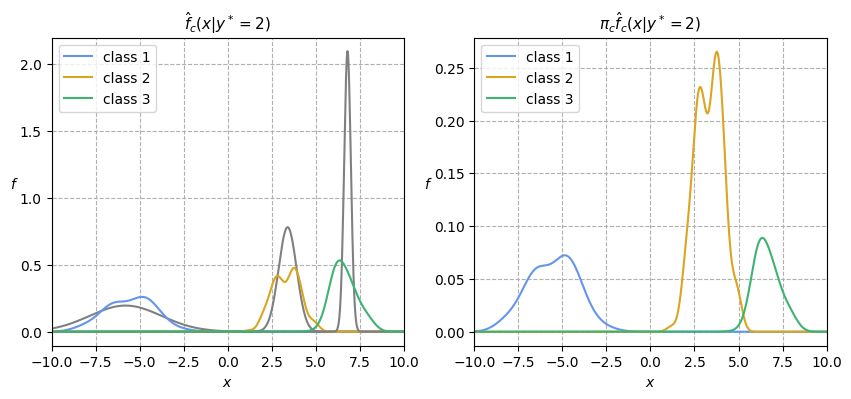

In [127]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

true_dist1 = norm.pdf(x_grid, loc=-5.8, scale=2.04)
axs[0].plot(x_grid, true_dist1, c="grey")
axs[0].plot(x_grid, scores1, c="cornflowerblue", label="class 1")
true_dist2 = norm.pdf(x_grid, loc=3.4, scale=0.51)
axs[0].plot(x_grid, true_dist2, c="grey")
axs[0].plot(x_grid, scores2, c="goldenrod", label="class 2")
true_dist3 = norm.pdf(x_grid, loc=6.8, scale=0.19)
axs[0].plot(x_grid, true_dist3, c="grey")
axs[0].plot(x_grid, scores3, c="mediumseagreen", label="class 3")
axs[0].set_title("$\hat{f}_c(x|y^*=2)$", fontsize=11)
axs[0].legend(fontsize=10)
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$f$", rotation=0)
axs[0].set_xlim(-10, 10)
axs[0].set_ylim(top=2.2)
axs[0].grid(linestyle="--")

axs[1].plot(x_grid, m_train1 / m_train * scores1, c="cornflowerblue", label="class 1")
axs[1].plot(x_grid, m_train2 / m_train * scores2, c="goldenrod", label="class 2")
axs[1].plot(x_grid, m_train3 / m_train * scores3, c="mediumseagreen", label="class 3")
axs[1].set_title("$\\pi_c \\hat{f}_c(x|y^*=2)$", fontsize=11)
axs[1].legend(fontsize=10)
axs[1].set_xlim(-10, 10)
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$f$", rotation=0)
axs[1].grid(linestyle="--")

plt.show()

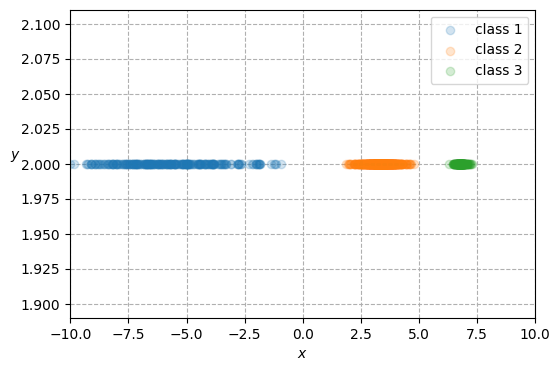

In [128]:
classifier = CKDEClassification().fit(x_train, y_train, y_star, labels_train,
                                      bandwidths_x=bandwidths_x, bandwidths_y=bandwidths_y)
labels_pred = classifier.predict(x_test)


plt.figure(figsize=(6, 4))

plt.scatter(x_test[labels_pred==1], x_test[labels_pred==1]*0 + y_star[0], alpha=0.2, zorder=2, label="class 1")
plt.scatter(x_test[labels_pred==2], x_test[labels_pred==2]*0 + y_star[0], alpha=0.2, zorder=2, label="class 2")
plt.scatter(x_test[labels_pred==3], x_test[labels_pred==3]*0 + y_star[0], alpha=0.2, zorder=2, label="class 3")

plt.legend()
plt.xlabel("$x$")
plt.ylabel("$y$", rotation=0)
plt.xlim(-10, 10)
plt.grid(linestyle="--")
plt.show()